In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Import modules

In [ ]:
import pandas as pd

formspring = "/content/gdrive/My Drive/formspring_data_BERT_210323.csv"

In [ ]:
import pickle as pc
import os
import numpy as np
import csv
import torch

# torch 버전 확인
print("Pytorch Version: ", torch.__version__)

# GPU 사용 가능한지 여부 확인
if torch.cuda.is_available():
    
    # PyTorch 에게 GPU 사용할거라고 알려주기
    device = torch.device("cuda")
    
    print("There are %d GPU(s) available." % torch.cuda.device_count())
    print("We will use the GPU:", torch.cuda.get_device_name(0))
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")

Pytorch Version:  1.8.1+cu101
There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## Installing the Hugging Face Library

In [ ]:
!pip install transformers

In [ ]:
def load_data(filename):
    data = list()
    label = list()
    
    f = open(filename, 'r', encoding='latin1')
    reader = csv.reader(f)
    for idx, line in enumerate(reader):
        if idx == 0:
            continue

        data.append(line[0])
        label.append(int(line[2]))

    f.close()
    
    # data 랑 label 사이즈 일치 여부 확인
    assert len(data) == len(label)
    return data, label

In [ ]:
formspring_data, formspring_label = load_data(formspring)

In [ ]:
import pandas as pd

df = pd.DataFrame(formspring_data)

In [ ]:
import re
import string

df4 = df[0].apply(lambda x: x.replace('Q:',' ').replace('A:',' ').replace('<br>',' '))
df4 = df4.apply(lambda x: x.lower())
df4 = df4.apply((lambda x: re.sub(r"(https?|http)://[-a-zA-Z0-9+&@#/%?=~_|!:,.;]*[-a-zA-Z0-9+&@#/%=~_|]", "", x)))
df4 = df4.apply((lambda x: re.sub(r"&#039;", "\'", x)))
df4 = df4.apply((lambda x: re.sub(r"&quot;", "", x)))
df4 = df4.apply((lambda x: re.sub(r"&amp;", "", x)))

In [ ]:
import numpy as np

data = list(np.array(df4.tolist()))

In [ ]:
formspring_data = data

In [ ]:
print("Size of imdb data: {}".format(len(formspring_data)))
print("Size of imdb label: {}".format(len(formspring_label)))

Size of imdb data: 12773
Size of imdb label: 12773


In [ ]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_label, test_label = train_test_split(formspring_data, formspring_label, test_size = 0.2, random_state = 42)

In [ ]:
print("Size of train data: {}".format(len(train_data)))
print("Size of train label: {}".format(len(train_label)))

Size of train data: 10218
Size of train label: 10218


In [ ]:
import numpy as np
test_data = np.array(test_data)
test_label = np.array(test_label)

In [ ]:
from transformers import BertTokenizer

# BERT tokenizer 불러오기
print("Loading BERT tokenizer...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
# 하나의 sentence 에 대해 BertTokenizer 적용

# Print the original sentence.
print("Original: ", train_data[0])
print()

# Print the sentence split into tokens.
print("Tokenized: ", tokenizer.tokenize(train_data[0]))
print()

# Print the sentence mapped to token ids.
print("Token IDs: ", tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_data[0])))
print()

Original:    haha thanks to you or i would have never been named an honerary ninja :)   haha yeeee im awesome(:

Tokenized:  ['ha', '##ha', 'thanks', 'to', 'you', 'or', 'i', 'would', 'have', 'never', 'been', 'named', 'an', 'hon', '##era', '##ry', 'ninja', ':', ')', 'ha', '##ha', 'ye', '##ee', '##e', 'im', 'awesome', '(', ':']

Token IDs:  [5292, 3270, 4283, 2000, 2017, 2030, 1045, 2052, 2031, 2196, 2042, 2315, 2019, 10189, 6906, 2854, 14104, 1024, 1007, 5292, 3270, 6300, 4402, 2063, 10047, 12476, 1006, 1024]



#### Sentences to IDs

`tokenizer.encode` 함수를 이용하여 모든 문장들에 대해 위의 과정들을 한꺼번에 처리합니다.

In [ ]:
# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []

# For every sentence
for sent in train_data:
    # 'encode' will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the '[CLS]' token to the start.
    #   (3) Append the '[SEP]' token to the end.
    #   (4) Map tokens to their IDs.
    
    encoded_sent = tokenizer.encode(sent, 
                                    add_special_tokens=True,
                                    max_length = 62)
    
    # Add the encoded sentence to the list
    input_ids.append(encoded_sent)

# Print train data[0]
print("Original: ", train_data[0])
print()
print("Token IDs: ", input_ids[0])

# Print special tokens and tokenized sentence
print("\n[CLS] token: {:}, ID: {:}".format(tokenizer.cls_token, tokenizer.cls_token_id))
print("\n[PAD] token: {:}, ID: {:}".format(tokenizer.pad_token, tokenizer.pad_token_id))
print("\n[SEP] token: {:}, ID: {:}".format(tokenizer.sep_token, tokenizer.sep_token_id))
print("\nTokenized: ", tokenizer.convert_ids_to_tokens(input_ids[0]))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original:    haha thanks to you or i would have never been named an honerary ninja :)   haha yeeee im awesome(:

Token IDs:  [101, 5292, 3270, 4283, 2000, 2017, 2030, 1045, 2052, 2031, 2196, 2042, 2315, 2019, 10189, 6906, 2854, 14104, 1024, 1007, 5292, 3270, 6300, 4402, 2063, 10047, 12476, 1006, 1024, 102]

[CLS] token: [CLS], ID: 101

[PAD] token: [PAD], ID: 0

[SEP] token: [SEP], ID: 102

Tokenized:  ['[CLS]', 'ha', '##ha', 'thanks', 'to', 'you', 'or', 'i', 'would', 'have', 'never', 'been', 'named', 'an', 'hon', '##era', '##ry', 'ninja', ':', ')', 'ha', '##ha', 'ye', '##ee', '##e', 'im', 'awesome', '(', ':', '[SEP]']


#### Padding & Truncating

`tf.keras.preprocessing.sequence.pad_sequences` 를 이용하여 **MAXLEN** 만큼 padding 과정을 진행합니다.

In [ ]:
print("Max length: ", max([len(each) for each in input_ids]))

Max length:  62


In [ ]:
import tensorflow as tf
print("Tensorflow version: {}".format(tf.__version__))

MAXLEN = 62

input_ids = tf.keras.preprocessing.sequence.pad_sequences(input_ids, 
                                                          maxlen=MAXLEN, dtype="long", value=0, truncating="post", padding="post")

print("\nDone.")

Tensorflow version: 2.5.0

Done.


#### Attention Masks

In [ ]:
# Create attention masks
attention_masks = []

# For every sentence
for sent in input_ids:
    # Create the attention mask.
    #  - If a token ID is 0, then it's padding, set the mask to 0.
    #  - If a token ID is not 0 ( > 0), then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

#### Training & Validation Split




In [ ]:
# Use train_test_split to split our data into train and validation sets for training
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, valid_inputs, train_labels, valid_labels = train_test_split(input_ids, train_label, random_state=2018, test_size=0.1)

# Do the same for the masks.
train_masks, valid_masks, _, _ = train_test_split(attention_masks, train_label, random_state=2018, test_size=0.1)

# print train_inputs, valid_inputs
print(train_inputs[:1])
print(train_masks[:1])

[[  101 10047 11471  2024  2017 11471  1029  1024  1011  1013  2748 10047
  11471  1012  1012  1012  8840  2140   102     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0]]
[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


#### Converting to PyTorch Data Types

In [ ]:
# Convert all inputs and labels into torch tensors, the required data type for our model.
train_inputs = torch.tensor(train_inputs)
valid_inputs = torch.tensor(valid_inputs)

train_labels = torch.tensor(train_labels)
valid_labels = torch.tensor(valid_labels)

train_masks = torch.tensor(train_masks)
valid_masks = torch.tensor(valid_masks)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it here.
# For fine-tuning BERT on a specific task, we recommend a batch size of 16 or 32.

batch_size = 32

train_labels, valid_labels = (torch.FloatTensor(t) for t in (train_labels.float(), valid_labels.float()))

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
valid_data = TensorDataset(valid_inputs, valid_masks, valid_labels)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=batch_size)

In [ ]:
from torch import nn

class BertCNN(nn.Module):
    
    def __init__(self, embed_size, bert_model):
        super(BertCNN, self).__init__()
        filter_sizes = [2,3]
        num_filters = 32
        self.convs1 = nn.ModuleList([nn.Conv2d(4, num_filters, (K, embed_size)) for K in filter_sizes])
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(len(filter_sizes)*num_filters, 1)
        self.sigmoid = nn.Sigmoid()
        self.bert_model = bert_model

    def forward(self, x, input_masks, token_type_ids):
        x = self.bert_model(x, attention_mask=input_masks, token_type_ids=token_type_ids)[2][-4:]
        x = torch.stack(x, dim=1)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] 
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        x = torch.cat(x, 1)
        x = self.dropout(x)  
        logit = self.fc1(x)
        return self.sigmoid(logit)

## Train our classification model

In [ ]:
from transformers import BertModel, AdamW, BertConfig

# Load BertForSequenceClassfication, the pretrained BERT model 
# with a single linear classification layer on top.
bert_model = BertModel.from_pretrained("bert-base-uncased", output_hidden_states = True) # whether the model returns all hidden states

model = BertCNN(768, bert_model)

# Tell PyTorch to run this model on the GPU
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertCNN(
  (convs1): ModuleList(
    (0): Conv2d(4, 32, kernel_size=(2, 768), stride=(1, 1))
    (1): Conv2d(4, 32, kernel_size=(3, 768), stride=(1, 1))
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, 

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print("The BERT model has {:} different named parameters.\n".format(len(params)))
print("=== Embedding Layer ===\n")

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("\n==== First Transformer ====\n")

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("\n==== Output Layer====\n")

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 205 different named parameters.

=== Embedding Layer ===

convs1.0.weight                                         (32, 4, 2, 768)
convs1.0.bias                                                  (32,)
convs1.1.weight                                         (32, 4, 3, 768)
convs1.1.bias                                                  (32,)
fc1.weight                                                   (1, 64)

==== First Transformer ====

fc1.bias                                                        (1,)
bert_model.embeddings.word_embeddings.weight            (30522, 768)
bert_model.embeddings.position_embeddings.weight          (512, 768)
bert_model.embeddings.token_type_embeddings.weight          (2, 768)
bert_model.embeddings.LayerNorm.weight                        (768,)
bert_model.embeddings.LayerNorm.bias                          (768,)
bert_model.encoder.layer.0.attention.self.query.weight    (768, 768)
bert_model.encoder.layer.0.attention.self.query.bias       

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for "Weight Decay fix"
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (we recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
print(len(train_dataloader))
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

288


In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=-1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Take a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round(elapsed))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random

# Set the seed value all over the place to make this reproducible
def set_seed(seed_val):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

In [ ]:
import torch.nn.functional as F

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

seed_val = 42
set_seed(seed_val)

# Store the average loss after each epoch so we can plot them
loss_values = []

loss_fn = nn.BCELoss()

# For each epoch
for epoch in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))
    print('Training...')
    
    # Measure how long the training epoch takes.
    t0 = time.time()
    
    # Reset the total loss for this epoch.
    total_loss = 0.
    
    # Put the model into training mode.
    # Don't be mislead -- the call to 'train' just changes the "mode", it doesn't "perform" the training.
    # 'dropout' and 'bachnorm' layers behave differently during training vs test
    model.train()
    
    # For each batch of training data
    for step, batch in enumerate(train_dataloader):
        
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress
            print("Batch {:>5,} of {:>5,}. Elapsed: {:}.".format(step, len(train_dataloader), elapsed))
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()
        
        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, b_input_mask, token_type_ids=None)

        print("outputs :", outputs)

        print("b_labels :", b_labels.unsqueeze(1))

        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = loss_fn(outputs, b_labels.unsqueeze(1))
        
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value from the tensor.
        total_loss += loss.item()
        
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.        
        optimizer.step()
        
        # Update the learning rate.
        scheduler.step()
    
    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)
    
    print("")
    print("Average training loss: {0:.2f}".format(avg_train_loss))
    print("Training epoch took: {:}".format(format_time(time.time() - t0)))
    
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on our validation set.
    
    print("")
    print("Running Validation...")
    
    t0 = time.time()
    
    # Put the model in evaluation mode -- the dropout layers behave differently during evaluation
    model.eval()
    
    # Tracking variables
    eval_loss, eval_acc = 0., 0.
    
    

    # Evaluate data for one epoch
    for valid_step, batch in enumerate(valid_dataloader):
        
        val_preds = []

        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
            
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, b_input_mask, token_type_ids=None)
            
        # Get the "logits" output by the model.
        # The "logits" are the output values prior to applying an activation function like the softmax
        loss = loss_fn(outputs, b_labels.unsqueeze(1))

        outputs = outputs.cpu().numpy().flatten()
        val_preds += [ int(p >= 0.5) for p in outputs ]
        
        # Move logits and labels to CPU
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_acc = flat_accuracy(val_preds, label_ids)
        
        # Accumulate the total accuracy.
        eval_acc += tmp_eval_acc       
    
    # Report the final accuracy for this validation run.
    print("Accuracy: {0:.2f}".format(eval_acc / (valid_step + 1)))
    print("Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")        

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
        [0.9971],
        [0.9981],
        [0.9990],
        [0.9982],
        [0.9949]], device='cuda:0', grad_fn=<SigmoidBackward>)
b_labels : tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
outputs : tensor([[0.9980],
        [0.9968],
        [0.9976],
        [0.9975],
        [0.9987],
        [0.9988],
        [0.9976],
        [0.9990],
        [0.9983],
        [0.9482],
        [0.9984],
        [0.9995],
        [0.9984],
        [0.9902],
        [0.9989],
        [0.9989],
        [0.9957],
        [0.9994],
        [0.9977],


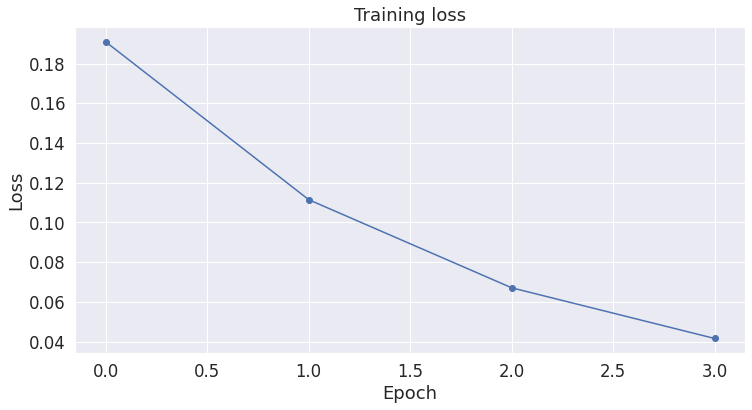

In [ ]:
# visualize training loss over all batches
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

## Performance on Test set

- `sklearn` 라이브러리의 `classification_report` 함수 이용하여 **accuracy, precision, recall, f1 score** 평가 지표를 이용하여 test dataset 에 대해 성능 확인

In [ ]:
type(test_data)

numpy.ndarray

In [ ]:
type(test_label)

numpy.ndarray

In [ ]:
print(test_data)

['  baby... nothing can ever break us apart... i love you so much and i want to be with you for ever. i really love you... for ever... and ever. *you are the only exception*. (l) <3 <3 <3 <3   ily2 u2665'
 '  does your stomach make noise when your terribly hungry?smh mines do all the time ughh:(   yeah sometimes or i just get a really sore head'
 '  do you have your own bank account?:   mes  they can be fun' ...
 "  the stupids is about a family mr and mrs stupid and their children. they're rather quite stupid. it's a comedy and is rather hilarious...they're just stupid! haha. it's awesome. they do something good  it's a nice story. only available on region 1 dvd :-(   ohhhh  well thats a faillll because i don't have a multiregional player :( i might watch it online or something  thanks :d"
 '  u mad?   nope im good'
 '  who asks people if they know me why do i see it all the time who is it that cares   you have a fan d00d. can you sign my bewbs?']


In [ ]:
len(test_label)

2555

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in test_data:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = tf.keras.preprocessing.sequence.pad_sequences(input_ids, maxlen=MAXLEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# For every sentence
for sent in input_ids:
    # Create the attention mask.
    #  - If a token ID is 0, then it's padding, set the mask to 0.
    #  - If a token ID is not 0 ( > 0), then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(test_label)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Token indices sequence length is longer than the specified maximum sequence length for this model (612 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

preds = []
# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, b_input_mask, token_type_ids=None)

  preds += list(outputs.cpu().numpy().flatten())

  label_ids = b_labels.to('cpu').numpy()

  true_labels.extend(label_ids.flatten())


print('DONE.')

Predicting labels for 2,555 test sentences...
DONE.


In [ ]:
pre = [int(x >= 0.5) for x in preds]
print(pre)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
len(pre)

2555

In [ ]:
len(true_labels)

2555

In [ ]:
# accuracy, precision, recall, f1 score 성능 확인
from sklearn.metrics import classification_report
    
target_names = ['negative', 'positive']

print(classification_report(true_labels, pre, digits=4, target_names=target_names))

              precision    recall  f1-score   support

    negative     0.5693    0.5455    0.5571       143
    positive     0.9731    0.9755    0.9743      2412

    accuracy                         0.9515      2555
   macro avg     0.7712    0.7605    0.7657      2555
weighted avg     0.9505    0.9515    0.9510      2555

